# Xray Radial Stacked Profiles (CAMELS)

In [2]:
pip install yt

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyxsim

Note: you may need to restart the kernel to use updated packages.


In [4]:
import yt
import pyxsim
from tqdm import tqdm

import h5py
import numpy as np
import pylab as plt

import os
from regions import RectangleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs
from astropy.io import fits

from soxs.utils import soxs_cfg
soxs_cfg.set("soxs", "bkgnd_nH", "0.018") # avoid configparser error by specifying here
import soxs
from concurrent.futures import ProcessPoolExecutor, as_completed

soxs : [WARNING  ] 2025-05-19 08:05:43,467 Setting 'soxs_data_dir' to /home/jovyan/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [5]:
snap = "060"
r_norm_max = 1
r_norm_min = 1e-2
nbins = 8
#hm = ["1011", "1112", "1213"]
hm = "3"
ex = ["ex0", "ex1", "ex2", "ex3"]

In [6]:
def process_single_halo(args):
    haloID, label, num = args
    try:
        f_snapshot = f'/home/jovyan/Data/Sims/IllustrisTNG/EX/EX_{num}/snapshot_{snap}.hdf5'
        f_catalog  = f'/home/jovyan/Data/FOF_Subfind/IllustrisTNG/EX/EX_{num}/groups_{snap}.hdf5'
        
        f = h5py.File(f_catalog, 'r')
        lentype_h = f['Group/GroupLenType'][:]
        r200_all = f['Group/Group_R_Crit200'][:]
        c_all = f['Group/GroupPos'][:]
        f.close()

        r2001 = r200_all[haloID]
        center = c_all[haloID]
        
        offset = np.sum(lentype_h[:haloID], axis=0)
        start = offset[0]
        end = offset[0] + lentype_h[haloID, 0]
        indices = np.arange(start, end)
        
        with h5py.File(f_snapshot, "r") as f_in:
            header_snap = dict(f_in['Header'].attrs)
            parttype0 = f_in["PartType0"]
            keys = list(parttype0.keys())

            filename = f"halo_{label}_{haloID}.hdf5"
            with h5py.File(filename, "w") as f_out:
                grp = f_out.create_group("PartType0")
                for key in keys:
                    data = parttype0[key][indices]
                    grp.create_dataset(key, data=data)

                header_grp = f_out.create_group('Header')
                header_grp.attrs['NumFilesPerSnapshot'] = 1
                header_grp.attrs['MassTable'] = header_snap['MassTable']
                header_grp.attrs['BoxSize'] = header_snap['BoxSize']
                header_grp.attrs['Time'] = header_snap['Time']
                header_grp.attrs['Redshift'] = header_snap['Redshift']
                gas_count = len(grp['Density'][:])
                header_grp.attrs['NumPart_ThisFile'] = np.array([gas_count,0,0,0,0,0])
                header_grp.attrs['HubbleParam'] = header_snap['HubbleParam']
                header_grp.attrs['Omega0'] = header_snap['Omega0']
                header_grp.attrs['OmegaLambda'] = header_snap['OmegaLambda']
                header_grp.attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
                header_grp.attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
                header_grp.attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

        ds = yt.load(filename)

        def hot_gas(pfilter, data):
            pfilter1 = data[pfilter.filtered_type, "temperature"] > 3.0e5
            pfilter2 = data["PartType0", "StarFormationRate"] == 0.0
            pfilter3 = data["PartType0", "GFM_CoolingRate"] < 0.0
            return (pfilter1 & pfilter2) & pfilter3

        yt.add_particle_filter("hot_gas", function=hot_gas,
                               filtered_type='gas', requires=["temperature","density"])
        ds.add_particle_filter("hot_gas")

        source_model = pyxsim.CIESourceModel(
            "apec", 0.5, 2.0, 10000,
            ("hot_gas", "metallicity"),
            temperature_field=("hot_gas", "temperature"),
            emission_measure_field=("hot_gas", "emission_measure"),
        )

        c = ds.arr(center, "code_length").to("kpc")
        r200 = ds.arr(r2001, "code_length").to("kpc")

        xray_fields = source_model.make_source_fields(ds, 0.5, 2)
        proj2 = ds.proj(xray_fields[0], axis='z', center=c)
        frb2 = proj2.to_frb(2* r_norm_max * r200, (500, 500), center=c)
        xray_data = frb2[xray_fields[0]]

        ny, nx = xray_data.shape
        center_x, center_y = nx // 2, ny // 2
        y, x = np.indices((ny, nx))
        rp = (np.sqrt((x - center_x)**2 + (y - center_y)**2))/r200
        radii = rp * (2* r_norm_max * r200/500.0)
        #r_bins = np.linspace(0, r_norm_max, nbins + 1)
        r_bins = np.logspace(np.log10(r_norm_min), np.log10(r_norm_max), nbins + 1)
        
        def bin_profile(quantity):
            binned = np.array([
                np.mean(quantity[(radii >= r_bins[i]) & (radii < r_bins[i+1])])
                if np.any((radii >= r_bins[i]) & (radii < r_bins[i+1])) else np.nan
                for i in range(nbins)
            ])
            return np.nan_to_num(binned, nan=0.0)

        profile = bin_profile(xray_data)

        for f in [filename, filename + ".ewah"]:
            if os.path.exists(f):
                os.remove(f)

        return (haloID, profile)

    except Exception as e:
        print(f"❌ Failed for halo {haloID}: {e}")
        return (haloID, np.zeros(nbins))


def combined_xray_profiles(halo_list, label, num, max_workers=5):
    xray_profiles = np.zeros((len(halo_list), nbins))

    with ProcessPoolExecutor(max_workers=5) as executor:
        futures = {executor.submit(process_single_halo, (haloID, label, num)): i for i, haloID in enumerate(halo_list)}
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"{label} Halos"):
            i = futures[future]
            haloID, profile = future.result()
            xray_profiles[i, :] = profile

    xray_mean = np.nanmean(xray_profiles, axis=0)
    xray_sem = np.nanstd(xray_profiles, axis=0, ddof=1) / np.sqrt(len(halo_list))

    np.savez(f"xray_profile100_{label}_{hm}.npz", xray_mean=xray_mean, xray_sem=xray_sem)
    print(f"✅ Saved xray_profile100_{label}_{hm}.npz")


In [7]:
data0 = np.load("ex0_4bins.npz")
combined_xray_profiles(data0[f"ex0_{hm}"], ex[0], 0)

data1 = np.load("ex1_4bins.npz")
combined_xray_profiles(data1[f"ex1_{hm}"], ex[1], 1)

data2 = np.load("ex2_4bins.npz")
combined_xray_profiles(data2[f"ex2_{hm}"], ex[2], 2)

data3 = np.load("ex3_4bins.npz")
combined_xray_profiles(data3[f"ex3_{hm}"], ex[3], 3)


'''
data0 = np.load("ex0.npz")
combined_xray_profiles(data0["ex0_1011"], ex[0], hm[0])
combined_xray_profiles(data0["ex0_1112"], ex[0], hm[1])
#combined_xray_profiles(data0["ex0_1213"], ex[0], hm[2])


data1 = np.load("ex1.npz")
combined_xray_profiles(data1["ex1_1011"], ex[1], hm[0])
combined_xray_profiles(data1["ex1_1112"], ex[1], hm[1])
#combined_xray_profiles(data1["ex1_1213"], ex[1], hm[2])

data2 = np.load("ex2.npz")
combined_xray_profiles(data2["ex2_1011"], ex[2], hm[0])
combined_xray_profiles(data2["ex2_1112"], ex[2], hm[1])
#combined_xray_profiles(data2["ex2_1213"], ex[2], hm[2])

data3 = np.load("ex3.npz")
#combined_xray_profiles(data3["ex3_1011"], ex[3], hm[0])
#combined_xray_profiles(data3["ex3_1112"], ex[3], hm[1])
combined_xray_profiles(data3["ex3_1213"], ex[3], hm[2])
'''

ex0 Halos:   0%|          | 0/52 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 08:05:51,290 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:05:51,292 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:05:51,297 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:05:51,299 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:05:51,884 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:05:51,886 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:05:51,886 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:05:51,887 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:05:51,887 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:05:51,888 Parameters: domain_left_edge          = [0

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:06:10,892 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:06:10,894 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:06:10,975 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:06:10,976 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:06:11,193 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:06:11,277 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:06:11,279 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:06:11,280 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:06:11,387 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:06:11,391 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:06:11,476 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:06:11,477 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:08:44,382 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:08:44,893 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:08:46,091 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:08:46,487 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:08:46,500 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex0 Halos:  10%|▉         | 5/52 [03:15<14:13, 18.16s/it]   yt : [INFO     ] 2025-05-19 08:09:01,796 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:09:02,383 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:09:02,384 Parameters: domain_dimensions         = [1

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:09:22,283 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:09:22,285 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:09:22,287 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:09:22,288 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:09:23,887 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:09:23,890 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:09:23,975 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:09:23,976 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-19 08:09:23,978 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:09:23,980 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:09:23,982 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:09:23,983 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:09:24,177 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:09:24,179 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:09:24,181 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:09:24,182 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:11:59,491 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:11:59,676 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:11:59,995 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:12:00,895 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:12:04,179 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex0 Halos:  19%|█▉        | 10/52 [06:29<12:37, 18.04s/it]yt : [INFO     ] 2025-05-19 08:12:16,894 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:12:17,177 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:12:17,179 Parameters: domain_dimensions         = [1 1

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:12:35,579 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:12:35,582 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:12:35,584 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:12:35,585 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:12:36,388 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:12:36,391 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:12:36,476 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:12:36,477 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:12:36,687 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:12:36,776 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:12:36,778 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:12:36,779 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:12:37,475 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:12:37,478 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:12:37,480 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:12:37,480 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:15:13,377 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:15:14,777 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:15:15,290 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:15:15,685 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex0 Halos:  27%|██▋       | 14/52 [09:40<15:36, 24.65s/it]yt : [INFO     ] 2025-05-19 08:15:26,586 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:15:26,588 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:15:26,589 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:15:26,590 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:15:48,393 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:15:48,477 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:15:48,480 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:15:48,481 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:15:49,876 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:15:49,878 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:15:49,880 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:15:49,881 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:15:50,088 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:15:50,090 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:15:50,174 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:15:50,175 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:15:52,682 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:15:52,685 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:15:52,687 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:15:52,688 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:18:24,982 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:18:26,075 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:18:26,287 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex0 Halos:  35%|███▍      | 18/52 [12:49<19:16, 34.02s/it]yt : [INFO     ] 2025-05-19 08:18:36,393 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:18:37,372 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:18:37,510 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:18:37,512 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:18:37,513 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:18:3

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:19:00,788 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:19:00,789 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:19:00,875 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:19:00,875 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:19:01,480 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:19:01,482 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:19:01,485 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:19:01,486 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:19:05,687 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:19:05,775 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:19:05,779 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:19:05,780 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:19:06,587 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:19:06,589 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:19:06,676 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:19:06,677 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:21:38,282 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:21:43,086 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex0 Halos:  40%|████      | 21/52 [15:57<34:34, 66.91s/it]yt : [INFO     ] 2025-05-19 08:21:43,789 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:21:44,891 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:21:45,105 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:21:47,082 Calculating time from 4.884e-01 to be 1.833e+17 seconds
ex0 Halos:  42%|████▏     | 22/52 [16:02<24:15, 48.50s/it]yt : [INFO     ] 2025-05-19 08:21:49,293 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:28:20,484 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:28:20,487 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:28:20,488 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:28:20,489 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:28:20,490 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 08:28:20,491 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 08:28:20,574 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 08:28:20,578 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 08:28:20,581 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 08:28:20,582 Parameters: hubble_constant           = 0.6711
yt : [WARNING  ] 2025-05-19 08:28:20,584 The hot_gas particle filter already exis

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:28:29,379 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:28:29,381 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:28:29,383 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:28:29,384 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:28:31,685 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:28:31,688 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:28:31,776 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:28:31,777 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:28:42,193 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:28:42,278 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:28:42,280 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:28:42,281 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:30:53,479 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex0 Halos:  69%|██████▉   | 36/52 [25:12<16:45, 62.82s/it]yt : [INFO     ] 2025-05-19 08:31:01,495 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:31:02,075 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:31:02,077 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:31:02,078 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:31:02,079 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:31:02,080 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 08:31:02,081 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 08:31:02,082 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 08:31:02,083 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

ex0 Halos:  77%|███████▋  | 40/52 [25:41<04:18, 21.56s/it]yt : [INFO     ] 2025-05-19 08:31:30,381 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:31:31,075 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:31:31,076 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:31:31,078 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:31:31,079 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:31:31,080 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 08:31:31,081 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 08:31:31,082 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 08:31:31,083 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 08:31:31,084 Parameters: omega_radiation           = 0.0
yt : [INFO    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:31:34,776 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:31:34,779 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:31:34,781 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:31:34,782 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:31:35,089 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:31:35,091 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:31:35,176 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:31:35,177 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:31:51,182 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:31:51,184 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:31:51,187 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:31:51,187 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:34:02,085 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex0 Halos:  79%|███████▉  | 41/52 [28:20<11:31, 62.85s/it]yt : [INFO     ] 2025-05-19 08:34:09,284 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:34:09,694 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:34:10,180 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:34:10,181 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:34:10,182 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:34:10,183 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:34:10,185 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 08:34:10,185 Parameters: current_redshift          = 1.0476023211521182
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:34:37,892 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
pyxsim : [INFO     ] 2025-05-19 08:34:42,076 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:34:42,080 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:34:42,082 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:34:42,083 Using temperature field '('hot_gas', 'temperature')'.
ex0 Halos:  87%|████████▋ | 45/52 [28:56<02:39, 22.86s/it]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:34:45,094 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:34:45,784 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:34:45,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:34:45,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:34:45,788 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:34:45,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 08:34:45,791 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 08:34:45,878 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 08:34:45,880 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 08:34:45,882 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 08:34:45,883 Parameters: hubble_constant    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:34:51,289 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:34:51,291 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:34:51,375 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:34:51,376 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:35:07,677 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:35:07,679 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:35:07,682 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:35:07,682 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:37:14,188 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex0 Halos:  88%|████████▊ | 46/52 [31:33<06:18, 63.10s/it]yt : [INFO     ] 2025-05-19 08:37:19,892 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:37:22,877 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:37:24,182 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:37:24,184 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:37:24,185 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:37:24,187 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:37:24,276 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 08:37:24,278 Parameters: current_redshift          = 1.0476023211521182
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:37:45,779 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:37:45,781 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:37:45,783 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:37:45,784 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:37:47,980 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex0 Halos:  96%|█████████▌| 50/52 [32:04<00:42, 21.38s/it]yt : [INFO     ] 2025-05-19 08:38:49,512 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:38:50,281 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex0 Halos: 100%|██████████| 52/52 [33:07<00:00, 38.23s/it]


✅ Saved xray_profile100_ex0_3.npz


ex1 Halos:   0%|          | 0/53 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 08:39:00,995 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:39:01,251 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:39:01,253 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:39:01,255 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:39:01,274 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:39:01,277 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 08:39:01,279 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 08:39:01,280 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 08:39:01,281 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 08:39:01,282 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-0

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:39:22,387 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:39:22,390 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:39:22,475 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:39:22,392 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:39:22,476 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-19 08:39:22,476 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:39:22,478 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:39:22,479 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:39:23,476 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:39:23,479 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:39:23,482 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:39:23,484 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:39:25,082 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:39:25,175 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:39:25,183 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:39:25,187 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:41:57,388 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:41:58,383 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:41:58,685 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:41:58,784 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:41:59,286 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:   9%|▉         | 5/53 [03:18<14:34, 18.21s/it]   yt : [INFO     ] 2025-05-19 08:42:13,690 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:42:14,276 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:42:14,278 Parameters: domain_dimensions         = [1

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:42:35,092 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:42:35,176 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:42:35,182 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:42:35,183 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:42:35,977 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:42:35,979 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:42:35,982 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:42:35,982 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:42:36,682 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:42:36,684 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:42:36,686 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:42:36,687 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:42:36,885 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:42:36,887 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:42:36,890 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:42:36,891 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:45:11,277 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:45:13,081 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:45:14,092 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:  11%|█▏        | 6/53 [06:22<58:26, 74.61s/it]yt : [INFO     ] 2025-05-19 08:45:17,590 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:45:18,090 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:  17%|█▋        | 9/53 [06:31<18:40, 25.46s/it]yt : [INFO     ] 2025-05-19 08:45:26,493 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:45:26,496 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:45:26,

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:45:48,679 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:45:48,683 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:45:48,685 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:45:48,686 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:45:49,886 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:45:49,888 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:45:49,890 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:45:49,891 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:45:50,777 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:45:50,779 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:45:50,782 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:45:50,783 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:45:52,377 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:45:52,379 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:45:52,381 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:45:52,382 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:48:22,883 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:  21%|██        | 11/53 [09:33<47:19, 67.61s/it]yt : [INFO     ] 2025-05-19 08:48:30,587 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:48:32,089 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:48:32,586 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:48:32,588 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:48:32,589 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:48:32,590 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:48:32,591 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 08:48:32,675 Parameters: current_redshift          = 1.0476023211521182
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:49:01,579 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:49:01,581 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:49:01,584 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:49:01,585 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:49:04,679 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:49:04,681 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:49:04,683 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:49:04,684 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:49:05,081 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:49:05,083 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:49:05,085 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:49:05,086 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:49:07,176 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:49:07,178 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:49:07,180 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:49:07,181 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:51:32,689 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:  30%|███       | 16/53 [12:43<35:53, 58.20s/it]yt : [INFO     ] 2025-05-19 08:51:41,290 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:51:41,383 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:51:41,394 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:51:41,697 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:51:41,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:51:41,699 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:51:41,700 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:51:41,775 Parameters: cosmologi

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:52:13,187 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:52:13,190 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:52:13,275 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:52:13,277 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:52:16,880 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:52:16,883 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:52:16,885 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:52:16,886 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:52:22,183 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:52:22,185 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:52:22,275 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:52:22,276 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:52:22,589 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:52:22,591 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:52:22,674 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:52:22,675 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:54:42,289 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:  40%|███▉      | 21/53 [15:52<33:27, 62.74s/it]yt : [INFO     ] 2025-05-19 08:54:50,385 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:54:50,978 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:54:50,980 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:54:50,981 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:54:50,982 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:54:50,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 08:54:50,984 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 08:54:50,984 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 08:54:50,985 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:55:23,675 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:55:23,677 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:55:23,679 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:55:23,680 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:55:25,384 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:55:25,386 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:55:25,388 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:55:25,389 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:55:34,193 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:55:34,274 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:55:34,277 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:55:34,278 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:55:34,775 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:55:34,777 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:55:34,780 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:55:34,781 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 08:57:55,090 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:  49%|████▉     | 26/53 [19:05<28:38, 63.66s/it]yt : [INFO     ] 2025-05-19 08:58:03,179 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 08:58:03,591 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 08:58:04,076 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 08:58:04,078 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 08:58:04,079 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 08:58:04,081 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 08:58:04,082 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 08:58:04,083 Parameters: current_redshift          = 1.0476023211521182
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:58:36,279 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:58:36,281 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:58:36,283 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:58:36,284 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:58:38,379 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:58:38,380 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:58:38,382 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:58:38,383 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:58:49,379 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:58:49,381 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:58:49,383 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:58:49,384 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 08:58:52,884 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 08:58:52,886 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 08:58:52,888 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 08:58:52,888 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:01:06,479 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:  58%|█████▊    | 31/53 [22:16<23:10, 63.22s/it]yt : [INFO     ] 2025-05-19 09:01:14,189 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:01:14,477 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:01:14,685 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:01:14,686 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:01:14,688 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:01:14,689 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:01:14,690 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:01:14,691 Parameters: current_redshift          = 1.0476023211521182
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:01:47,783 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:01:47,785 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:01:47,787 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:01:47,788 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:01:49,188 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:01:49,191 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:01:49,274 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:01:49,275 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:01:57,178 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:01:57,180 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:01:57,182 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:01:57,183 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:02:02,484 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:02:02,487 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:02:02,489 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:02:02,490 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:04:17,487 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:  68%|██████▊   | 36/53 [25:27<17:56, 63.33s/it]yt : [INFO     ] 2025-05-19 09:04:24,580 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:04:25,079 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:04:25,080 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:04:25,082 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:04:25,083 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:04:25,084 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:04:25,084 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 09:04:25,085 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 09:04:25,086 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

ex1 Halos:  75%|███████▌  | 40/53 [25:56<04:30, 20.83s/it]yt : [INFO     ] 2025-05-19 09:04:54,494 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:04:54,990 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:04:54,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:04:55,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:04:55,076 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:04:55,077 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:04:55,078 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 09:04:55,079 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 09:04:55,080 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 09:04:55,081 Parameters: omega_radiation           = 0.0
yt : [INFO    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:05:01,688 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:05:01,690 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:05:01,692 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:05:01,693 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:05:08,290 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:05:08,375 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:05:08,379 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:05:08,380 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:05:14,486 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:05:14,490 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:05:14,575 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:05:14,576 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:07:27,577 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:  77%|███████▋  | 41/53 [28:37<12:33, 62.82s/it]yt : [INFO     ] 2025-05-19 09:07:34,481 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:07:34,774 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:07:35,287 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:07:35,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:07:35,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:07:35,291 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:07:35,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:07:35,377 Parameters: current_redshift          = 1.0476023211521182
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

ex1 Halos:  85%|████████▍ | 45/53 [29:08<02:49, 21.24s/it]yt : [INFO     ] 2025-05-19 09:08:06,193 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:08:06,686 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:08:06,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:08:06,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:08:06,690 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:08:06,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:08:06,692 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 09:08:06,693 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 09:08:06,775 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 09:08:06,776 Parameters: omega_radiation           = 0.0
yt : [INFO    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:08:12,292 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:08:12,376 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:08:12,378 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:08:12,379 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:08:19,694 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:08:19,697 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:08:19,776 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:08:19,778 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:08:26,888 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:08:26,976 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:08:26,980 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:08:26,981 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:10:39,288 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos:  87%|████████▋ | 46/53 [31:48<07:19, 62.84s/it]yt : [INFO     ] 2025-05-19 09:10:45,886 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:10:46,678 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:10:46,680 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:10:46,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:10:46,683 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:10:46,684 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:10:46,685 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 09:10:46,685 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 09:10:46,686 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

ex1 Halos:  94%|█████████▍| 50/53 [32:16<01:00, 20.08s/it]pyxsim : [INFO     ] 2025-05-19 09:11:16,283 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:11:16,286 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:11:16,288 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:11:16,290 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:11:17,595 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:11:17,597 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:11:17,600 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:11:17,601 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:12:46,881 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex1 Halos: 100%|██████████| 53/53 [34:00<00:00, 38.50s/it]


✅ Saved xray_profile100_ex1_3.npz


ex2 Halos:   0%|          | 0/46 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 09:13:02,493 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:13:02,595 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:13:02,676 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:13:02,678 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:13:02,682 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:13:04,491 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:13:04,493 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:13:04,575 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:13:04,576 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:13:04,578 Parameters: cosmological_simulation

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:13:23,586 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:13:23,587 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:13:23,587 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-19 09:13:23,588 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:13:25,091 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:13:25,178 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:13:25,176 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:13:25,181 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:13:25,183 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:13:25,184 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-19 09:13:25,186 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:13:25,187 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:15:57,485 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:15:58,478 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:16:01,587 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:16:02,481 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:16:02,481 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:   4%|▍         | 2/46 [03:10<57:51, 78.90s/it]   yt : [INFO     ] 2025-05-19 09:16:13,277 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:16:15,977 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:16:15,979 Parameters: domain_dimensions         = [1

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:16:36,185 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:16:36,189 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:16:36,191 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:16:36,192 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:16:40,680 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:16:40,683 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:16:40,685 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:16:40,686 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:16:41,393 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:16:41,476 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:16:41,478 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:16:41,479 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:16:42,590 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:16:42,676 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:16:42,679 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:16:42,680 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:19:13,577 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:19:14,192 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:19:15,887 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:  17%|█▋        | 8/46 [06:30<22:23, 35.35s/it]yt : [INFO     ] 2025-05-19 09:19:30,087 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:19:30,286 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:19:32,587 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:19:32,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:19:32,678 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:19:32,679 Parameters: domain_right_edge

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:19:53,080 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:19:53,083 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:19:53,086 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:19:53,087 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:19:56,780 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:19:56,782 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:19:56,784 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:19:56,785 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:19:57,090 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:19:57,092 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:19:57,177 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:19:57,178 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:19:58,986 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:19:59,075 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:19:59,077 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:19:59,078 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:22:30,486 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:22:32,982 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:  26%|██▌       | 12/46 [09:44<27:37, 48.75s/it]yt : [INFO     ] 2025-05-19 09:22:41,384 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:22:42,976 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:22:43,784 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:22:43,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:22:43,875 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:22:43,876 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:22:43,877 Parameters: cosmologi

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:23:07,487 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:23:07,489 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:23:07,575 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:23:07,577 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:23:09,289 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:23:09,374 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:23:09,377 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:23:09,378 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:23:13,178 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:23:13,181 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:23:13,183 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:23:13,184 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:23:18,788 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:23:18,790 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:23:18,875 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:23:18,876 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:25:41,780 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:25:45,880 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:  37%|███▋      | 17/46 [12:55<22:54, 47.38s/it]yt : [INFO     ] 2025-05-19 09:25:52,396 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:25:52,982 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:25:52,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:25:52,985 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:25:52,987 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:25:52,988 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:25:52,989 Parameters: current_redshift          = 1.0476023211521182
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:26:19,292 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:26:19,375 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:26:19,378 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:26:19,378 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:26:23,686 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:26:23,688 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:26:23,691 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:26:23,692 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:26:29,381 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:26:29,383 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:26:29,385 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:26:29,386 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:26:33,981 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:26:33,982 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:26:33,984 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:26:33,985 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:28:52,593 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:28:53,077 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:  48%|████▊     | 22/46 [16:04<18:19, 45.81s/it]yt : [INFO     ] 2025-05-19 09:29:03,189 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:29:03,289 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:29:03,688 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:29:03,691 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:29:03,692 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:29:03,693 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:29:03,694 Parameters: cosmological_simulation   = True
yt : [INFO

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:29:27,792 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:29:28,285 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:29:28,286 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:29:28,287 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:29:28,288 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:29:28,290 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:29:28,375 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 09:29:28,375 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 09:29:28,376 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 09:29:28,378 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 09:29:28,379 Parameters: hubble_constant    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:29:48,191 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:29:48,193 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:29:48,275 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:29:48,276 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:29:49,387 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:29:49,476 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:29:49,478 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:29:49,479 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:32:03,390 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:  57%|█████▋    | 26/46 [19:13<21:08, 63.42s/it]yt : [INFO     ] 2025-05-19 09:32:09,775 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:32:12,074 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:32:14,575 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:32:14,579 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:32:14,581 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:32:14,582 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:32:14,583 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:32:14,675 Parameters: current_redshift          = 1.0476023211521182
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:32:40,592 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:32:41,086 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:32:41,087 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:32:41,089 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:32:41,089 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:32:41,091 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:32:41,091 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 09:32:41,174 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 09:32:41,175 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 09:32:41,176 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 09:32:41,177 Parameters: hubble_constant    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:32:54,089 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:32:54,092 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:32:54,176 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:32:54,177 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:33:01,686 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:33:01,688 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:33:01,690 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:33:01,775 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:33:04,784 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:33:04,786 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:33:04,788 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:33:04,875 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:35:18,580 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:  67%|██████▋   | 31/46 [22:27<15:55, 63.72s/it]yt : [INFO     ] 2025-05-19 09:35:26,594 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:35:27,090 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:35:27,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:35:27,093 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:35:27,175 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:35:27,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:35:27,177 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 09:35:27,178 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 09:35:27,179 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:35:54,592 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:  76%|███████▌  | 35/46 [23:03<04:09, 22.71s/it]pyxsim : [INFO     ] 2025-05-19 09:36:01,885 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:36:01,888 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:36:01,890 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:36:01,891 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:36:03,377 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:36:03,881 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:36:03,882 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:36:03,884 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:36:03,885 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:36:03,886 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:36:03,887 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 09:36:03,974 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 09:36:03,975 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 09:36:03,976 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 09:36:03,977 Parameters: hubble_constant    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:36:12,993 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:36:13,076 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:36:13,078 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:36:13,079 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:36:25,689 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:36:25,776 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:36:25,782 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:36:25,783 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:38:33,382 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:38:38,577 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:  78%|███████▊  | 36/46 [25:42<10:35, 63.60s/it]yt : [INFO     ] 2025-05-19 09:38:43,075 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:38:43,985 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:38:43,987 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:38:44,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:38:44,077 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:38:44,078 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:38:44,079 Parameters: current_redshift          = 1.0476023211521182
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:39:08,876 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:39:08,878 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:39:08,881 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:39:08,882 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:39:10,878 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:  87%|████████▋ | 40/46 [26:19<02:21, 23.53s/it]pyxsim : [INFO     ] 2025-05-19 09:39:16,790 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:39:16,792 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:39:16,875 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:39:16,876 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:39:18,384 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:39:18,887 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:39:18,889 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:39:18,890 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:39:18,891 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:39:18,975 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:39:18,976 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 09:39:18,977 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 09:39:18,979 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 09:39:18,980 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 09:39:18,981 Parameters: hubble_constant    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:39:38,192 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:39:38,276 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:39:38,278 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:39:38,279 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:41:44,081 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:41:45,888 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos:  91%|█████████▏| 42/46 [28:56<02:59, 44.85s/it]yt : [INFO     ] 2025-05-19 09:41:53,696 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:41:54,195 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:41:54,197 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:41:54,198 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:41:54,276 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:41:54,278 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:41:54,279 Parameters: current_redshift          = 1.0476023211521182
yt : [I

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:42:10,002 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex2 Halos: 100%|██████████| 46/46 [29:48<00:00, 38.88s/it]


✅ Saved xray_profile100_ex2_3.npz


ex3 Halos:   0%|          | 0/51 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 09:42:52,179 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:42:52,290 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:42:52,375 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:42:52,378 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:42:52,575 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:42:52,983 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:42:52,985 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:42:52,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:42:52,987 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:42:52,988 Parameters: cosmological_simulation

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:43:12,475 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:43:12,477 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:43:12,478 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:43:12,479 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-19 09:43:12,485 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:43:12,487 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:43:12,575 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:43:12,577 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:43:12,580 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:43:12,580 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:43:12,581 Using temperature field '('hot_gas', 'temperature')'.
pyxsim : [INFO     ] 2025-05-19 09:43:12,582 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:43:13,083 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:43:13,088 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:43:13,177 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:43:13,180 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:45:47,387 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:45:47,684 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:45:48,089 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:45:48,896 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:45:49,409 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  10%|▉         | 5/51 [03:17<13:49, 18.04s/it]   yt : [INFO     ] 2025-05-19 09:46:02,689 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:46:02,795 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:46:03,294 Parameters: current_time              = 1.83265600

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:46:22,788 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:46:22,790 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:46:22,792 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:46:22,793 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:46:23,687 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:46:23,689 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:46:23,691 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:46:23,692 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:46:25,075 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:46:25,077 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:46:25,079 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:46:25,080 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:46:26,082 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:46:26,086 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:46:26,088 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:46:26,089 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:48:59,692 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:49:00,984 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  12%|█▏        | 6/51 [06:19<55:20, 73.78s/it]yt : [INFO     ] 2025-05-19 09:49:04,576 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:49:07,888 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:49:08,191 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  16%|█▌        | 8/51 [06:26<25:35, 35.70s/it]yt : [INFO     ] 2025-05-19 09:49:11,791 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:49:11,793 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:49:11,

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:49:35,182 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:49:35,185 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:49:35,187 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:49:35,188 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:49:36,277 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:49:36,279 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:49:36,281 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:49:36,281 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:49:40,181 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:49:40,183 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:49:40,185 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:49:40,186 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:49:40,786 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:49:40,788 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:49:40,791 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:49:40,792 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:52:13,985 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:52:16,186 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  24%|██▎       | 12/51 [09:37<28:09, 43.31s/it]yt : [INFO     ] 2025-05-19 09:52:22,899 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:52:23,592 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:52:23,679 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:52:25,388 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:52:25,390 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:52:25,475 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:52:2

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:52:47,787 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:52:47,789 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:52:47,792 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:52:47,793 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:52:49,884 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:52:49,886 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:52:49,889 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:52:49,889 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:52:53,485 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:52:53,487 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:52:53,490 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:52:53,491 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:52:53,890 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:52:53,975 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:52:53,977 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:52:53,978 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:55:25,375 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:55:26,784 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
yt : [INFO     ] 2025-05-19 09:55:27,185 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  35%|███▌      | 18/51 [12:50<18:20, 33.36s/it]yt : [INFO     ] 2025-05-19 09:55:35,975 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:55:36,386 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:55:36,388 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:55:36,389 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:55:36,390 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:55:36,391 Parameters: cosmologi

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:56:00,078 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:56:00,081 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:56:00,083 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:56:00,084 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:56:03,284 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:56:03,286 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:56:03,289 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:56:03,375 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:56:05,081 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:56:05,084 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:56:05,086 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:56:05,087 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:56:05,675 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:56:05,677 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:56:05,680 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:56:05,681 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 09:58:34,277 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  41%|████      | 21/51 [15:53<32:38, 65.30s/it]yt : [INFO     ] 2025-05-19 09:58:41,175 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 09:58:41,592 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 09:58:41,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 09:58:41,676 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 09:58:41,677 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 09:58:41,678 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 09:58:41,679 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 09:58:41,680 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 09:58:41,681 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:59:11,978 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:59:11,980 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:59:11,983 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:59:11,984 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:59:15,989 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:59:15,992 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:59:16,077 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:59:16,079 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:59:16,876 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:59:16,878 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:59:16,881 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:59:16,882 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 09:59:19,179 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 09:59:19,180 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 09:59:19,182 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 09:59:19,183 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 10:01:39,380 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  51%|█████     | 26/51 [18:58<26:24, 63.38s/it]yt : [INFO     ] 2025-05-19 10:01:46,781 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 10:01:47,483 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 10:01:47,486 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 10:01:47,487 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 10:01:47,488 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 10:01:47,489 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 10:01:47,575 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 10:01:47,576 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 10:01:47,577 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 10:02:13,877 Allocating for 5296 particles
pyxsim : [INFO     ] 2025-05-19 10:02:24,675 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:02:24,678 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:02:24,680 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:02:24,681 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:02:26,891 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:02:26,974 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:02:26,976 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:02:26,977 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:02:29,677 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:02:29,679 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:02:29,681 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:02:29,682 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:02:34,679 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:02:34,681 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:02:34,683 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:02:34,684 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 10:04:50,875 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  61%|██████    | 31/51 [22:09<21:01, 63.06s/it]yt : [INFO     ] 2025-05-19 10:04:57,474 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 10:04:57,978 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 10:04:57,980 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 10:04:57,981 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 10:04:57,982 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 10:04:57,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 10:04:57,984 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 10:04:57,985 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 10:04:57,986 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 10:05:22,875 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 10:05:23,383 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 10:05:23,384 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 10:05:23,385 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 10:05:23,386 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 10:05:23,387 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 10:05:23,474 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 10:05:23,475 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 10:05:23,476 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 10:05:23,477 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 10:05:23,478 Parameters: hubble_constant    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:05:35,889 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:05:35,891 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:05:35,977 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:05:35,978 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:05:36,876 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:05:36,879 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:05:36,881 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:05:36,882 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:05:44,284 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:05:44,285 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:05:44,375 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:05:44,376 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 10:08:04,189 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  71%|███████   | 36/51 [25:23<16:02, 64.14s/it]yt : [INFO     ] 2025-05-19 10:08:11,587 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 10:08:12,277 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 10:08:12,279 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 10:08:12,281 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 10:08:12,282 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 10:08:12,283 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 10:08:12,284 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 10:08:12,285 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 10:08:12,286 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

ex3 Halos:  78%|███████▊  | 40/51 [25:52<03:53, 21.23s/it]yt : [INFO     ] 2025-05-19 10:08:40,192 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 10:08:40,686 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 10:08:40,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 10:08:40,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 10:08:40,690 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 10:08:40,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 10:08:40,774 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 10:08:40,775 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 10:08:40,776 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 10:08:40,777 Parameters: omega_radiation           = 0.0
yt : [INFO    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:08:46,384 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:08:46,386 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:08:46,388 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:08:46,389 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:08:52,486 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:08:52,488 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:08:52,491 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:08:52,575 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:08:59,687 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:08:59,689 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:08:59,776 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:08:59,777 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 10:11:12,193 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  80%|████████  | 41/51 [28:31<10:25, 62.59s/it]yt : [INFO     ] 2025-05-19 10:11:19,389 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 10:11:19,981 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 10:11:19,983 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 10:11:19,984 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 10:11:19,985 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 10:11:19,986 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 10:11:19,987 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 10:11:20,075 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 10:11:20,077 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

ex3 Halos:  88%|████████▊ | 45/51 [29:02<02:17, 22.89s/it]yt : [INFO     ] 2025-05-19 10:11:49,786 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 10:11:50,287 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 10:11:50,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 10:11:50,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 10:11:50,291 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 10:11:50,293 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 10:11:50,375 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 10:11:50,375 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 10:11:50,376 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 10:11:50,377 Parameters: omega_radiation           = 0.0
yt : [INFO    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:11:59,384 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:11:59,386 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:11:59,388 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:11:59,475 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:12:02,893 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:12:02,976 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:12:02,978 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:12:02,979 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-05-19 10:12:11,380 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-19 10:12:11,383 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-19 10:12:11,385 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-05-19 10:12:11,386 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 10:14:20,891 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500
ex3 Halos:  90%|█████████ | 46/51 [31:40<04:51, 58.23s/it]yt : [INFO     ] 2025-05-19 10:14:27,585 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 10:14:28,177 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 10:14:28,179 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 10:14:28,180 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 10:14:28,181 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 10:14:28,182 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 10:14:28,183 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 10:14:28,184 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 10:14:28,185 Parameters: 

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

ex3 Halos: 100%|██████████| 51/51 [32:40<00:00, 38.44s/it]


✅ Saved xray_profile100_ex3_3.npz


'\ndata0 = np.load("ex0.npz")\ncombined_xray_profiles(data0["ex0_1011"], ex[0], hm[0])\ncombined_xray_profiles(data0["ex0_1112"], ex[0], hm[1])\n#combined_xray_profiles(data0["ex0_1213"], ex[0], hm[2])\n\n\ndata1 = np.load("ex1.npz")\ncombined_xray_profiles(data1["ex1_1011"], ex[1], hm[0])\ncombined_xray_profiles(data1["ex1_1112"], ex[1], hm[1])\n#combined_xray_profiles(data1["ex1_1213"], ex[1], hm[2])\n\ndata2 = np.load("ex2.npz")\ncombined_xray_profiles(data2["ex2_1011"], ex[2], hm[0])\ncombined_xray_profiles(data2["ex2_1112"], ex[2], hm[1])\n#combined_xray_profiles(data2["ex2_1213"], ex[2], hm[2])\n\ndata3 = np.load("ex3.npz")\n#combined_xray_profiles(data3["ex3_1011"], ex[3], hm[0])\n#combined_xray_profiles(data3["ex3_1112"], ex[3], hm[1])\ncombined_xray_profiles(data3["ex3_1213"], ex[3], hm[2])\n'

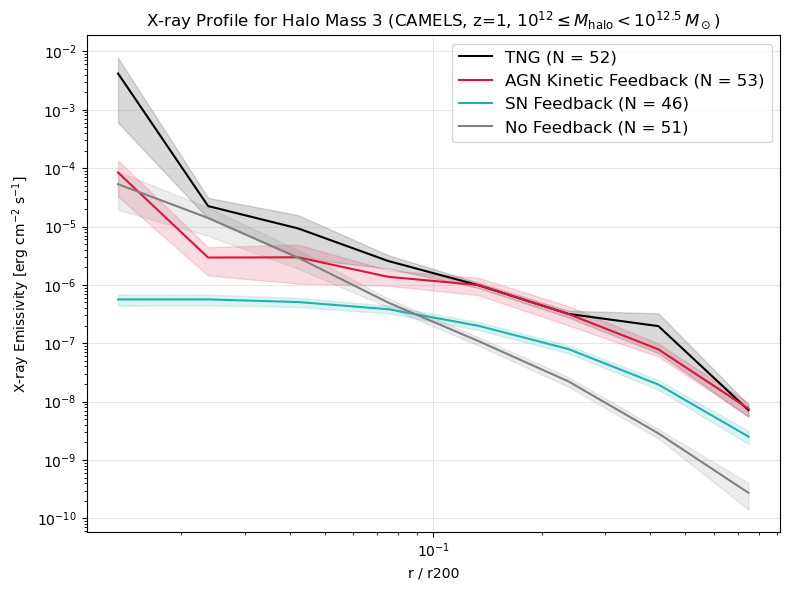

In [11]:
import numpy as np
import pylab as plt

#bin_edges = np.linspace(0, r_norm_max, nbins + 1)
#bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

bin_edges = np.logspace(np.log10(r_norm_min), np.log10(r_norm_max), nbins + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
#print(bin_centers)
data0 = np.load("ex0_4bins.npz")
data1 = np.load("ex1_4bins.npz")
data2 = np.load("ex2_4bins.npz")
data3 = np.load("ex3_4bins.npz")

N0 = len(data0["ex0_3"])
N1 = len(data1["ex1_3"])
N2 = len(data2["ex2_3"])
N3 = len(data3["ex3_3"])

meaning = [
    f"TNG (N = {N0})",
    f"AGN Kinetic Feedback (N = {N1})",
    f"SN Feedback (N = {N2})",
    f"No Feedback (N = {N3})"]

colors = ["black", "crimson", "lightseagreen", "grey"]

hmv = "3"
plt.figure(figsize=(8, 6))
label = "ex1"
for label, color, model in zip(ex, colors, meaning):
    filename = f"xray_profile100_{label}_{hmv}.npz"
    data = np.load(filename)
                        
    xray_mean = data["xray_mean"]
    xray_sem = data["xray_sem"]
                        
    plt.plot(bin_centers, xray_mean, label=model, color=color)
    plt.fill_between(bin_centers, xray_mean - xray_sem, xray_mean + xray_sem, alpha=0.15, color=color)
    
plt.xscale("log")
plt.yscale("log")
#plt.xlim(1e-2, 1)
#plt.ylim(10**-(10.5), 10**-(5.5))
plt.xlabel("r / r200")
plt.ylabel("X-ray Emissivity [erg cm$^{-2}$ s$^{-1}$]")
plt.title(f"X-ray Profile for Halo Mass {hmv} (CAMELS, z=1, $10^{{12}} \\leq M_{{\\mathrm{{halo}}}} < 10^{{12.5}} \\, M_\\odot$)")
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"xray100_CAMELS_{hmv}.png", dpi=900)
plt.show()

## X-ray radial profile for one halo only

yt : [INFO     ] 2025-05-19 01:47:17,555 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-19 01:47:17,652 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-19 01:47:17,653 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 01:47:17,654 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 01:47:17,655 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-19 01:47:17,656 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 01:47:17,657 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-19 01:47:17,657 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-19 01:47:17,658 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-19 01:47:17,658 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 01:47:17,659 Parameters: hubble_constant    

Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 01:47:51,563 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2_keV')) 500 by 500


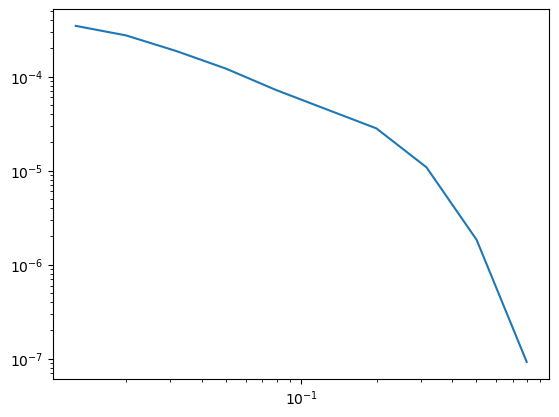

In [13]:
import numpy as np
import pylab as plt

num = 2
snap = "060"
haloID = 0
r_norm_min = 1e-2
r_norm_max = 1
nbins = 10
label = "puchi"

f_snapshot = f'/home/jovyan/Data/Sims/IllustrisTNG/EX/EX_{num}/snapshot_{snap}.hdf5'
f_catalog  = f'/home/jovyan/Data/FOF_Subfind/IllustrisTNG/EX/EX_{num}/groups_{snap}.hdf5'

f = h5py.File(f_catalog, 'r')
lentype_h = f['Group/GroupLenType'][:]
r200_all = f['Group/Group_R_Crit200'][:]
c_all = f['Group/GroupPos'][:]
f.close()

r2001 = r200_all[haloID]
center = c_all[haloID]

offset = np.sum(lentype_h[:haloID], axis=0)
start = offset[0]
end = offset[0] + lentype_h[haloID, 0]
indices = np.arange(start, end)

with h5py.File(f_snapshot, "r") as f_in:
    header_snap = dict(f_in['Header'].attrs)
    parttype0 = f_in["PartType0"]
    keys = list(parttype0.keys())

    filename = f"halo_{label}_{haloID}.hdf5"
    with h5py.File(filename, "w") as f_out:
        grp = f_out.create_group("PartType0")
        for key in keys:
            data = parttype0[key][indices]
            grp.create_dataset(key, data=data)

        header_grp = f_out.create_group('Header')
        header_grp.attrs['NumFilesPerSnapshot'] = 1
        header_grp.attrs['MassTable'] = header_snap['MassTable']
        header_grp.attrs['BoxSize'] = header_snap['BoxSize']
        header_grp.attrs['Time'] = header_snap['Time']
        header_grp.attrs['Redshift'] = header_snap['Redshift']
        gas_count = len(grp['Density'][:])
        header_grp.attrs['NumPart_ThisFile'] = np.array([gas_count,0,0,0,0,0])
        header_grp.attrs['HubbleParam'] = header_snap['HubbleParam']
        header_grp.attrs['Omega0'] = header_snap['Omega0']
        header_grp.attrs['OmegaLambda'] = header_snap['OmegaLambda']
        header_grp.attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
        header_grp.attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
        header_grp.attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

ds = yt.load(filename)

def hot_gas(pfilter, data):
    pfilter1 = data[pfilter.filtered_type, "temperature"] > 3.0e5
    pfilter2 = data["PartType0", "StarFormationRate"] == 0.0
    pfilter3 = data["PartType0", "GFM_CoolingRate"] < 0.0
    return (pfilter1 & pfilter2) & pfilter3

yt.add_particle_filter("hot_gas", function=hot_gas,
                       filtered_type='gas', requires=["temperature","density"])
ds.add_particle_filter("hot_gas")

source_model = pyxsim.CIESourceModel(
    "apec", 0.5, 2.0, 10000,
    ("hot_gas", "metallicity"),
    temperature_field=("hot_gas", "temperature"),
    emission_measure_field=("hot_gas", "emission_measure"),
)

c = ds.arr(center, "code_length").to("kpc")
r200 = ds.arr(r2001, "code_length").to("kpc")

xray_fields = source_model.make_source_fields(ds, 0.5, 2)
proj2 = ds.proj(xray_fields[0], axis='z', center=c)
frb2 = proj2.to_frb(2* r_norm_max * r200, (500, 500), center=c)
xray_data = frb2[xray_fields[0]]

ny, nx = xray_data.shape
center_x, center_y = nx // 2, ny // 2
y, x = np.indices((ny, nx))
rp = (np.sqrt((x - center_x)**2 + (y - center_y)**2))/r200
radii = rp * (2* r_norm_max * r200/500.0)
#r_bins = np.linspace(0, r_norm_max, nbins + 1)
r_bins = np.logspace(np.log10(r_norm_min), np.log10(r_norm_max), nbins + 1)

def bin_profile(quantity):
    binned = np.array([
        np.mean(quantity[(radii >= r_bins[i]) & (radii < r_bins[i+1])])
        if np.any((radii >= r_bins[i]) & (radii < r_bins[i+1])) else np.nan
        for i in range(nbins)
    ])
    return np.nan_to_num(binned, nan=0.0)

profile = bin_profile(xray_data)
bin_centers = np.sqrt(r_bins[:-1] * r_bins[1:])
plt.plot(bin_centers, profile)
plt.xscale("log")
plt.yscale("log")
plt.show()